<a href="https://colab.research.google.com/github/nielsrolf/AudioCLIP/blob/master/SIREN_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image and Audio to SIREN

This notebook contains an example of fitting a SIREN to an image and another one for audio. In both cases, some extrapolation is also shown for fun.

In [8]:
!pip install git+git://github.com/nielsrolf/siren-pytorch  &> /dev/null

# Audio

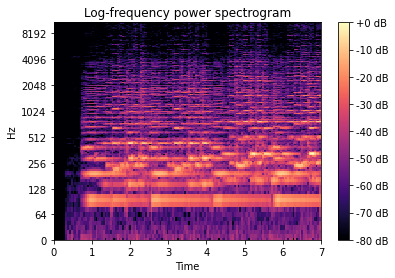

In [9]:
import librosa
import librosa.display
import os
import scipy.io.wavfile as wavfile
from IPython.display import Audio
import numpy as np
from matplotlib import image
from PIL import Image
import torch
from matplotlib import pyplot as plt
from torch import nn
from siren_pytorch import SirenNet, SirenWrapperNDim


if not os.path.exists('gt_bach.wav'):
  !wget https://vsitzmann.github.io/siren/img/audio/gt_bach.wav

rate = 44100


def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.rate, self.data = wavfile.read(filename)
        self.data = self.data.astype(np.float32)[::2] / np.max(np.abs(self.data))
        if len(self.data.shape) == 2:
          self.data = self.data[:,0]
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        amplitude = torch.Tensor(amplitude).view(-1, 1)
        return self.timepoints, amplitude


def play(audio):
  if not isinstance(audio, np.ndarray):
    audio = audio.cpu().detach().numpy()
  audio = audio.squeeze()
  # if len(audio.shape) == 3:
  #   audio = audio[:,:,0]
  # if len(audio.shape) == 2:
  #   audio = audio[0]
  display(Audio(audio, rate=rate))
  hop_length = 1024
  fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
  D = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)),
                              ref=np.max)
  specplot = librosa.display.specshow(D, y_axis='log', sr=rate, hop_length=hop_length,
                          x_axis='time', ax=ax)
  ax.set(title='Log-frequency power spectrogram')
  ax.label_outer()
  fig.colorbar(specplot, ax=ax, format="%+2.f dB")
  plt.show()


sample_audio = torch.tensor(AudioFile("/content/gt_bach.wav").data.reshape(-1, 1)).cuda()
play(sample_audio)


Gradient:  0.00011471828
tensor(0.0242)
Gradient:  0.00011471828


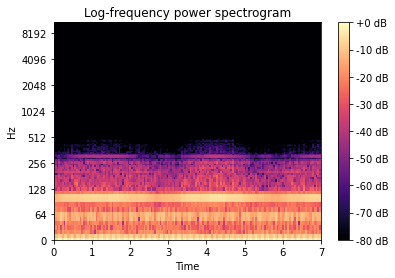

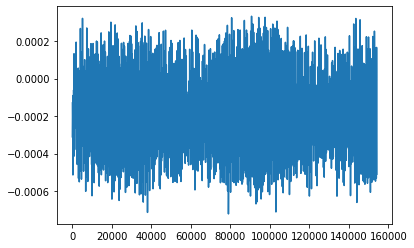

Gradient:  0.00010036175
Gradient:  0.002321756
Gradient:  0.015149333
Gradient:  0.014535649
Gradient:  0.03216329
Gradient:  0.034632824
Gradient:  0.07614129
Gradient:  0.038895052
Gradient:  0.07288539
tensor(0.0193)
Gradient:  0.030988483


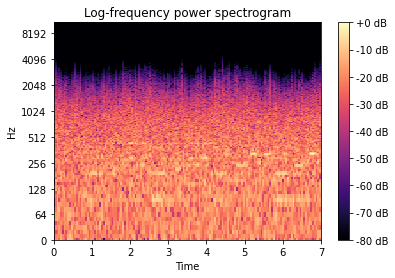

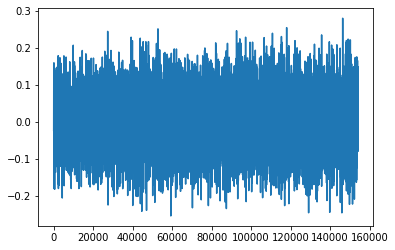

tensor(0.0194)
Gradient:  0.08018578


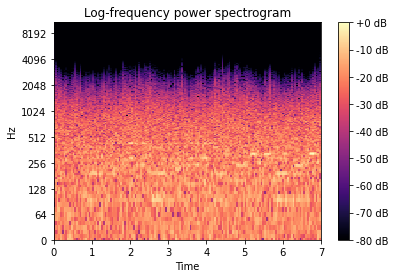

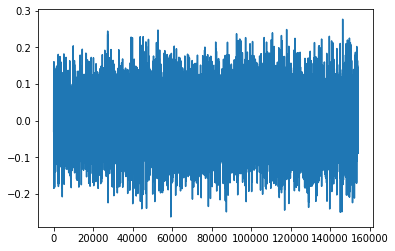

tensor(0.0193)
Gradient:  0.028999269


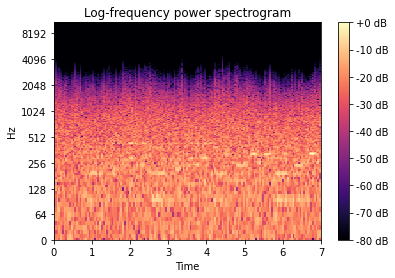

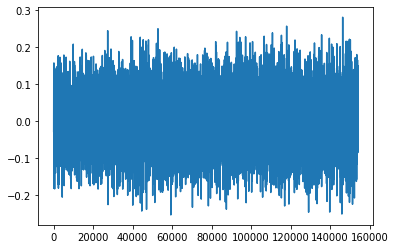

tensor(0.0194)
Gradient:  0.033672877


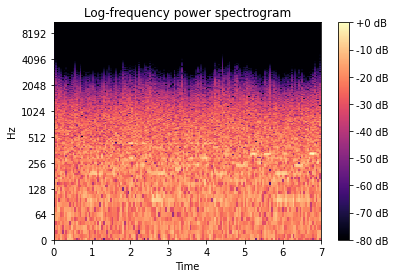

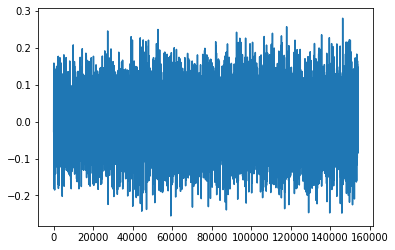

tensor(0.0194)
Gradient:  0.044273674


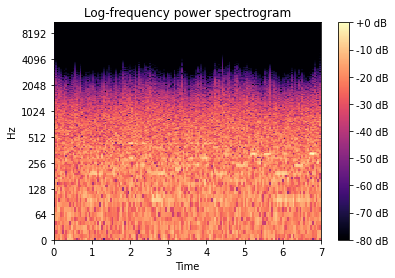

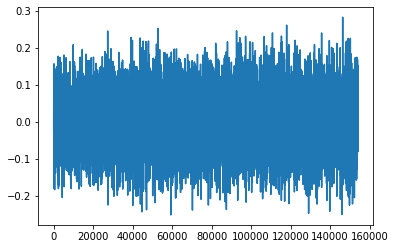

tensor(0.0193)
Gradient:  0.030693134


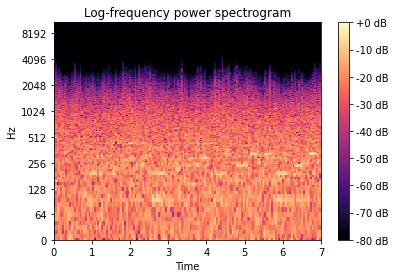

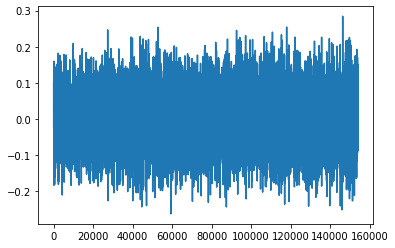

tensor(0.0194)
Gradient:  0.065381594


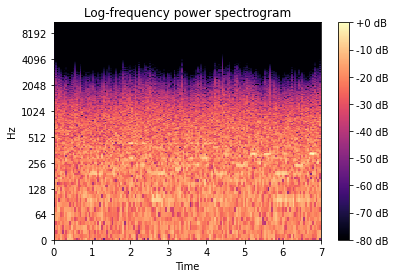

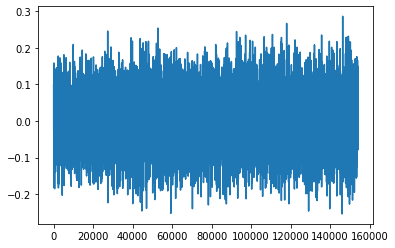

tensor(0.0194)
Gradient:  0.06180822


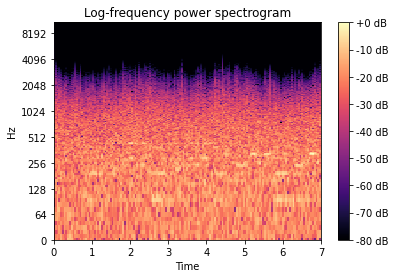

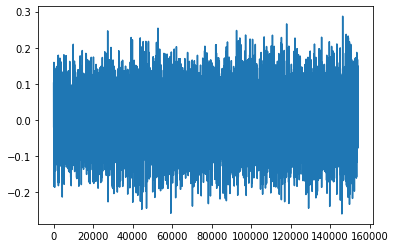

tensor(0.0193)
Gradient:  0.022927776


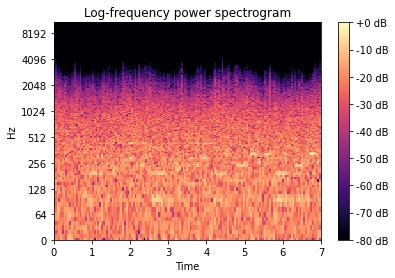

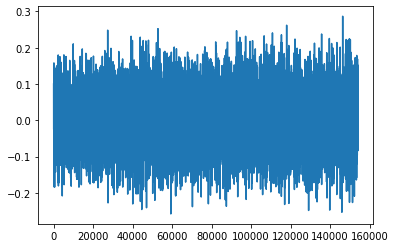

In [12]:
def get_gradient_magnitude(net):
  mean_grad = []
  for parameter in net.parameters():
    mean_grad += [parameter.grad.detach().cpu().abs().numpy().mean()]
  print("Gradient: ", np.mean(mean_grad))


def get_siren_decoder(output_shape, latent_dim=512):
  net = SirenNet(
      dim_in=1,
      dim_hidden=32,
      dim_out=1,
      num_layers=3,
      w0 = 300.,
      w0_initial = 3000.,
      use_bias = True,
      final_activation = None)

  decoder = SirenWrapperNDim(
      net,
      latent_dim = latent_dim,
      output_shape=output_shape
  )
  decoder.cuda()

  return decoder

decoder = get_siren_decoder(output_shape=sample_audio.shape)

latent = nn.Parameter(torch.zeros(512).normal_(0, 1)).to('cuda')


optim = torch.optim.Adam(lr=1e-4, params=decoder.parameters())



steps_till_summary = 1000
for step in range(10000):
  loss = decoder(sample_audio, latent = latent)
  optim.zero_grad()
  loss.backward()
  optim.step()
  if step < 100 and step % 10 == 0:
    get_gradient_magnitude(decoder)
  if step % steps_till_summary == 0:
    print(loss.cpu().detach())
    get_gradient_magnitude(decoder)
    pred_audio = decoder(latent = latent)
    play(pred_audio)
    plt.plot(pred_audio.cpu().detach().numpy().squeeze())
    plt.show()

In [ ]:
translated_grid = get_grid(sample_audio.squeeze().shape, 0, 2).cuda()
pred_audio = decoder(latent = latent, coords = translated_grid)
play(pred_audio)

# Image

In [ ]:
# load image as pixel array

def load_img(path='AdobeStock_53119595.jpeg', size=224):
  img = image.imread(path)
  img = np.array(Image.fromarray(img).resize([size, size]))
  img = torch.tensor(img).to('cuda') / 255.
  return img[None]

!wget https://catfriendly.com/wp-content/uploads/2019/06/AdobeStock_53119595.jpeg
!wget https://storage.googleapis.com/blog-images-backup/1*gHzJ4qDXA5jvxRfFBlBNiA.jpeg
!ls
def imshow(img):
  plt.figure(figsize=(8, 8))
  plt.imshow(img.cpu().detach().numpy().squeeze())
  plt.axis('off')
  plt.show()

img = load_img("/content/AdobeStock_53119595.jpeg")
imshow(img)

In [ ]:
net = SirenNet(
    dim_in=2,
    dim_hidden=256,
    dim_out=3,
    num_layers=5,
    w0 = 30.,
    w0_initial = 30.,
    use_bias = True,
    final_activation = None)

siren_decoder = SirenWrapperNDim(
    net,
    latent_dim = 512,
    output_shape=[224, 224, 3]
)
siren_decoder.cuda()
optim = torch.optim.Adam(lr=1e-4, params=siren_decoder.parameters())

latent = nn.Parameter(torch.zeros(512).normal_(0, 1)).cuda()



for step in range(2001):
  if step % 100 == 0:
    pred_img = siren_decoder(latent = latent) # (256, 256, 3)
    imshow(pred_img)
  loss = siren_decoder(img[0], latent = latent)
  optim.zero_grad()
  loss.backward()
  optim.step()

In [ ]:
from siren_pytorch.siren_pytorch import get_grid
larger_grid = get_grid([512, 512], -2, 2).cuda()
pred_img = siren_decoder(latent = latent, coords = larger_grid, output_shape=[512, 512])
imshow(pred_img)